# Determining the optimum alloy temperature

## The task:

In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. I have to build a model that will predict the temperature of the steel.

## Description of the processing steps:

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

## Initial data:

The data consists of files obtained from different sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

## Work plan:

* Download libraries and provided data
* Preprocessing
 * Primary data evaluation
 * Handling skips and duplicates
 * Working with data types
 * Create target and additional features:
     * Estimation of the initial and final temperature of the alloy
     * Total heating time in seconds
     * Number of heating iterations
 * Joining tables via `key` values
* Exploratory data analysis
* Building models
 * Separation of data into training and test samples, evaluation of features and their scaling
 * Compare the quality of different models and determine the most suitable
 * Model testing
* Writing a final conclusion for the customer

### 1. Loading libraries and provided data

I import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from catboost import Pool
import shap as shap

from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost
from sklearn.linear_model import LinearRegression


In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### 2. Preprocessing

### Initial evaluation of data

#### Electrode data

In [4]:
data_arc.head(5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


* There are no missing values in the electrode data
* The values of the date and the end of heating by the arc must be converted to the `datetime` format

#### Bulk material feed data (volume)

In [6]:
data_bulk.head(5)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [7]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


* There are many missing values in the dry material input data. This is probably due to the fact that at many stages there is no need to use them.
* The `float` data type reflects the provided data well.

#### Bulk material feed data (time)

In [8]:
data_bulk_time.head(5)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [9]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


* The number of gaps is exactly the same as their number in the `data_bulk` dataframe at each stage.
* `object` values must be converted to `datetime` format

#### Alloy gas purge data

In [10]:
data_gas.head(5)

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [11]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


* No missing values found
* Data types are appropriate for the task

#### Temperature measurement results

In [12]:
data_temp.head(5)

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

In [13]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


* Missing 2901 temperature measurement values. This is probably a technical measurement error.
* The values of the `Sampling time` column must be converted to the `datetime` format

#### Wire material data (volume)

In [14]:
data_wire.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [15]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


* There are a large number of missing values in almost all stages of the work - it was probably not necessary to use wire.
* Floating point number format meets project goals

#### Wire material data (time)

In [16]:
data_wire_time.head(5)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [17]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


* And again, the number of gaps in the time data matches the gaps in the data frame with the results of measurements on wire materials.
* `object` format data will be converted to `datetime`

### Handling gaps and duplicates

Some columns are almost entirely missing data. It is necessary to remove columns where more than 10% of the data is missing - they are insignificant in the operation of the temperature estimation model and are rarely used in the technological process, while they are replaced by data from other columns, since this is a repetition of the same procedure.

In this case, `NaN` values in sufficiently filled columns will be replaced by `0`.

I will apply all of the above to the procedures for using bulk and wire materials, for this I create a compact function.

In [18]:
def cleaning(df):
    columns = df.columns
    for i in columns:
        if (df[i].count() / df.shape[0]) < 0.1:
            df = df.drop(i, axis=1)
    df.fillna(0, inplace = True)
    return df

I do the cleaning.

In [19]:
data_bulk = cleaning(data_bulk)
data_bulk_time = cleaning(data_bulk_time)
data_wire = cleaning(data_wire)
data_wire_time = cleaning(data_wire_time)

I delete dataframe rows with temperature measurements where there are no actual results.

In [20]:
data_temp = data_temp.loc[~data_temp['Температура'].isnull()]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


As well as a line with batch numbers for which only one temperature measurement was made.

In [21]:
data_temp = data_temp[data_temp['key'].isin(data_temp['key'].value_counts()[data_temp['key'].value_counts() > 1].index)]
print('Строк с партиями, имеющих менее двух замеров, удалено: ', data_temp['key'].value_counts()[data_temp['key'].value_counts() < 2].shape[0])

Строк с партиями, имеющих менее двух замеров, удалено:  0


No gaps were found in the rest of the dataframes.

I turn to the processing of duplicates. I'm creating a function to count duplicates and remove them.

In [22]:
def dup(df):
    print('Дублированных значений обнаружено и удалено: ', df.loc[df.duplicated() == True].shape[0])
    df = df.drop_duplicates()

In [23]:
dup(data_arc)

Дублированных значений обнаружено и удалено:  0


In [24]:
dup(data_bulk)

Дублированных значений обнаружено и удалено:  0


In [25]:
dup(data_bulk_time)

Дублированных значений обнаружено и удалено:  0


In [26]:
dup(data_gas)

Дублированных значений обнаружено и удалено:  0


In [27]:
dup(data_temp)

Дублированных значений обнаружено и удалено:  0


In [28]:
dup(data_wire)

Дублированных значений обнаружено и удалено:  0


In [29]:
dup(data_wire_time)

Дублированных значений обнаружено и удалено:  0


Excellent, no duplicates were found in these data.

### Working with data types

I will convert the existing date columns from the `object` type to the `datetime` type.

In [30]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y-%m-%dT%H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y-%m-%dT%H:%M:%S")

data_bulk_time['Bulk 3'] = pd.to_datetime(data_bulk_time['Bulk 3'], format="%Y-%m-%dT%H:%M:%S")
data_bulk_time['Bulk 4'] = pd.to_datetime(data_bulk_time['Bulk 4'], format="%Y-%m-%dT%H:%M:%S")
data_bulk_time['Bulk 6'] = pd.to_datetime(data_bulk_time['Bulk 6'], format="%Y-%m-%dT%H:%M:%S")
data_bulk_time['Bulk 12'] = pd.to_datetime(data_bulk_time['Bulk 12'], format="%Y-%m-%dT%H:%M:%S")
data_bulk_time['Bulk 14'] = pd.to_datetime(data_bulk_time['Bulk 14'], format="%Y-%m-%dT%H:%M:%S")
data_bulk_time['Bulk 15'] = pd.to_datetime(data_bulk_time['Bulk 15'], format="%Y-%m-%dT%H:%M:%S")

data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format="%Y-%m-%dT%H:%M:%S")

data_wire_time['Wire 1'] = pd.to_datetime(data_wire_time['Wire 1'], format="%Y-%m-%dT%H:%M:%S")
data_wire_time['Wire 2'] = pd.to_datetime(data_wire_time['Wire 2'], format="%Y-%m-%dT%H:%M:%S")

### Create target and additional features

The target value should be the final alloy temperature. I make its calculation for the existing parties.

In [31]:
data_temp_first = pd.merge(data_temp.groupby('key')['Время замера'].agg('min'), data_temp, how="left", on="Время замера")
data_temp_final = pd.merge(data_temp.groupby('key')['Время замера'].agg('max'), data_temp, how="left", on="Время замера")
data = pd.merge(data_temp_first[['key','Температура']], data_temp_final[['key','Температура']], how="outer", on="key")
data = data.rename(columns={'Температура_x': 'temperature_first', 'Температура_y': 'temperature_final'})

In [32]:
data.head(5)

key  temperature_first  temperature_final
0    1             1571.0             1613.0
1    2             1581.0             1602.0
2    3             1596.0             1599.0
3    4             1601.0             1625.0
4    5             1576.0             1602.0

Calculation of features of heating duration in seconds and the number of iterations.

In [33]:
data_arc['heat_duration'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()
data_pivot = data_arc[['key','heat_duration']].groupby('key', as_index=False).agg(['sum','count'])
data_pivot.columns = ['heat_duration', 'heat_count']
data = pd.merge(data, data_pivot, how='left', on='key')

In [34]:
data.head(5)

key  temperature_first  temperature_final  heat_duration  heat_count
0    1             1571.0             1613.0         1098.0           5
1    2             1581.0             1602.0          811.0           4
2    3             1596.0             1599.0          655.0           5
3    4             1601.0             1625.0          741.0           4
4    5             1576.0             1602.0          869.0           4

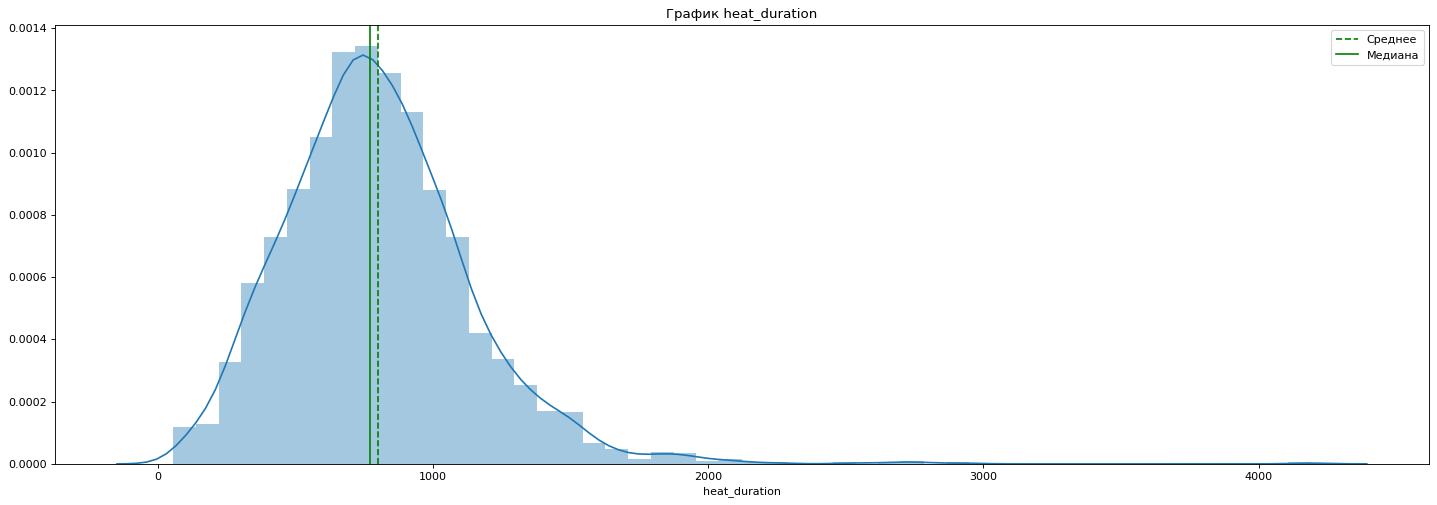

In [35]:
fig = plt.figure(figsize=(30, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
ax = fig.add_subplot(grid[:-1, :-1])
sns.distplot(data['heat_duration'], ax=ax)
ax.set(title='График '+'heat_duration')
ax.axvline(np.mean(data['heat_duration']),color='g', linestyle='--', label='Среднее')
ax.axvline(np.median(data['heat_duration']),color='g', linestyle='-', label='Медиана')
ax.legend()
fig.show()

The feature of the heating duration also has a normal distribution, which indicates the naturalness of the data provided.

### Joining tables via `key` values

I am merging existing dataframes by batch number. I summarize the power values to get all the power expended.

In [36]:
data = (data.merge(data_arc[['key', 'Активная мощность','Реактивная мощность']].groupby('key').sum(), how="left", on= "key")
            .merge(data_wire, how = 'left', on = 'key')
            .merge(data_bulk, how = 'left', on = 'key')
            .merge(data_gas, how = 'left', on = 'key')
       )


In [37]:
data.head()

key  temperature_first  temperature_final  heat_duration  heat_count  \
0    1             1571.0             1613.0         1098.0           5   
1    2             1581.0             1602.0          811.0           4   
2    3             1596.0             1599.0          655.0           5   
3    4             1601.0             1625.0          741.0           4   
4    5             1576.0             1602.0          869.0           4   

   Активная мощность  Реактивная мощность     Wire 1   Wire 2  Bulk 3  Bulk 4  \
0           4.878147             3.183241  60.059998  0.00000     0.0    43.0   
1           3.052598             1.998112  96.052315  0.00000     0.0    73.0   
2           2.525882             1.599076  91.160157  0.00000     0.0    34.0   
3           3.209250             2.060298  89.063515  0.00000     0.0    81.0   
4           3.347173             2.252643  89.238236  9.11456     0.0    78.0   

   Bulk 6  Bulk 12  Bulk 14  Bulk 15      Газ 1  
0     0.0    206.0    150.0    154.0  29.749986  
1     0.0    206.0    149.0    154.0  12.555561  
2     0.0    205.0    152.0    153.0  28.554793  
3     0.0    207.0    153.0    154.0  18.841219  
4     0.0    203.0    151.0    152.0   5.413692

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 16 columns):
key                    2475 non-null int64
temperature_first      2475 non-null float64
temperature_final      2475 non-null float64
heat_duration          2475 non-null float64
heat_count             2475 non-null int64
Активная мощность      2475 non-null float64
Реактивная мощность    2475 non-null float64
Wire 1                 2372 non-null float64
Wire 2                 2372 non-null float64
Bulk 3                 2407 non-null float64
Bulk 4                 2407 non-null float64
Bulk 6                 2407 non-null float64
Bulk 12                2407 non-null float64
Bulk 14                2407 non-null float64
Bulk 15                2407 non-null float64
Газ 1                  2473 non-null float64
dtypes: float64(14), int64(2)
memory usage: 328.7 KB


There are a small number of missing values after the join. For some algorithms to work correctly, it is necessary to fill them with zeros, and also rename the columns to English.

In [39]:
data = data.fillna(0)

data = data.rename(columns={'Активная мощность': 'active_power',
                            'Реактивная мощность': 'reactive_power',
                            'Газ 1': 'gas',
                            'Wire 1' : 'wire_1',
                            'Wire 2' : 'wire_2',
                            'Bulk 3' : 'bulk_3',
                            'Bulk 4' : 'bulk_4',
                            'Bulk 6' : 'bulk_6',
                            'Bulk 12' : 'bulk_12',
                            'Bulk 14' : 'bulk_14',
                            'Bulk 15' : 'bulk_15'})

I also discard the batch number, since this value will be incorrectly determined by the algorithms as being relevant for the calculations.

In [40]:
data = data.drop(['key'], axis = 1)

In [41]:
data.head(5)

temperature_first  temperature_final  heat_duration  heat_count  \
0             1571.0             1613.0         1098.0           5   
1             1581.0             1602.0          811.0           4   
2             1596.0             1599.0          655.0           5   
3             1601.0             1625.0          741.0           4   
4             1576.0             1602.0          869.0           4   

   active_power  reactive_power     wire_1   wire_2  bulk_3  bulk_4  bulk_6  \
0      4.878147        3.183241  60.059998  0.00000     0.0    43.0     0.0   
1      3.052598        1.998112  96.052315  0.00000     0.0    73.0     0.0   
2      2.525882        1.599076  91.160157  0.00000     0.0    34.0     0.0   
3      3.209250        2.060298  89.063515  0.00000     0.0    81.0     0.0   
4      3.347173        2.252643  89.238236  9.11456     0.0    78.0     0.0   

   bulk_12  bulk_14  bulk_15        gas  
0    206.0    150.0    154.0  29.749986  
1    206.0    149.0    154.0  12.555561  
2    205.0    152.0    153.0  28.554793  
3    207.0    153.0    154.0  18.841219  
4    203.0    151.0    152.0   5.413692

### Conclusion:

* Dataframes required for analysis and provided dataframes are loaded
* Initial evaluation of the data was carried out
* Discarded columns that do not have a minimum occupancy of 10%
* Passes processed, no duplicates found
* Columns containing date and time data are converted to `datetime` format
* Defined target feature (final temperature)
* Additional features are also defined: initial temperature, total power, heating duration and number of heating iterations
* The data obtained had a normal distribution, indicating the reliability of the available data
* All available data is summarized in the final dataframe
* The feature of the batch number - `key`, by which the merger took place, has been discarded, as it is unnecessary in the further work of the model

### 3. Exploratory data analysis

Getting started with exploratory data analysis.

To begin with, I will evaluate the data for ***outliers.***

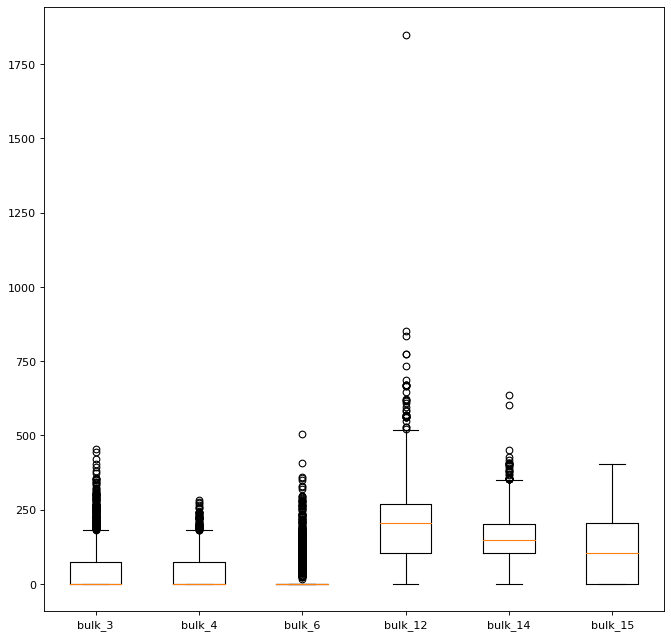

In [42]:
data_dict = {'bulk_3': data['bulk_3'].values, 'bulk_4': data['bulk_4'].values, 'bulk_6' : data['bulk_6'].values, 'bulk_12' : data['bulk_12'].values, 'bulk_14' : data['bulk_14'].values, 'bulk_15' : data['bulk_15'].values}
fig, ax = plt.subplots(figsize=(10, 10), dpi= 80)

ax.boxplot(data_dict.values())
ax.set_xticklabels(data_dict.keys())

plt.show()

There is a serious outlier at the bulk_12 stage. In addition, this column is the most prominent outlier in general.

I will search for anomalies in this column.

Количество аномалий:  35


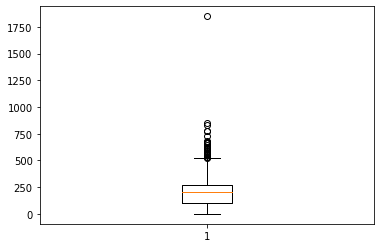

In [43]:
boxplot = plt.boxplot(data['bulk_12'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
df_outliers = data[data["bulk_12"].isin(outliers)] 
print("Количество аномалий: ", len(df_outliers))

In total, 35 anomalies were found in this column. I delete them.

In [44]:
data = data.drop(labels = df_outliers.index,axis = 0).reset_index(drop = True)

In [45]:
data

temperature_first  temperature_final  heat_duration  heat_count  \
0                1571.0             1613.0         1098.0           5   
1                1581.0             1602.0          811.0           4   
2                1596.0             1599.0          655.0           5   
3                1601.0             1625.0          741.0           4   
4                1576.0             1602.0          869.0           4   
...                 ...                ...            ...         ...   
2435             1570.0             1591.0          723.0           4   
2436             1554.0             1591.0          940.0           6   
2437             1571.0             1589.0          569.0           3   
2438             1591.0             1594.0          750.0           5   
2439             1569.0             1603.0          883.0           4   

      active_power  reactive_power      wire_1    wire_2  bulk_3  bulk_4  \
0         4.878147        3.183241   60.059998   0.00000     0.0    43.0   
1         3.052598        1.998112   96.052315   0.00000     0.0    73.0   
2         2.525882        1.599076   91.160157   0.00000     0.0    34.0   
3         3.209250        2.060298   89.063515   0.00000     0.0    81.0   
4         3.347173        2.252643   89.238236   9.11456     0.0    78.0   
...            ...             ...         ...       ...     ...     ...   
2435      3.210690        2.360777   89.150879   0.00000    21.0     0.0   
2436      4.203064        2.810185  114.179527   0.00000     0.0    63.0   
2437      2.212379        1.851269   94.086723   9.04800     0.0    85.0   
2438      3.408725        2.355428  118.110717   0.00000    90.0     0.0   
2439      4.098431        2.777865  110.160958  50.00528    47.0     0.0   

      bulk_6  bulk_12  bulk_14  bulk_15        gas  
0        0.0    206.0    150.0    154.0  29.749986  
1        0.0    206.0    149.0    154.0  12.555561  
2        0.0    205.0    152.0    153.0  28.554793  
3        0.0    207.0    153.0    154.0  18.841219  
4        0.0    203.0    151.0    152.0   5.413692  
...      ...      ...      ...      ...        ...  
2435     0.0    256.0    129.0    223.0   7.125735  
2436     0.0    256.0    129.0    226.0   9.412616  
2437     0.0    230.0    124.0    226.0   6.271699  
2438     0.0    206.0    129.0    207.0  14.953657  
2439     0.0    233.0    126.0    227.0  11.336151  

[2440 rows x 15 columns]

Estimation of the dependence of temperature on time.

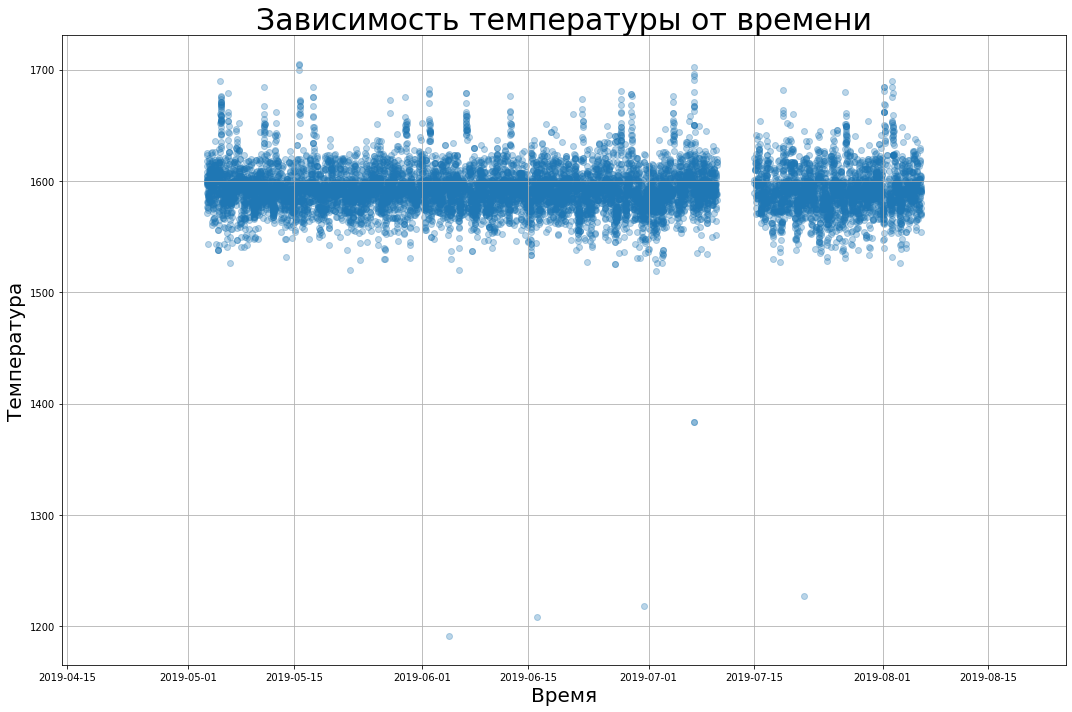

In [46]:
plt.figure(figsize=(15,10))
plt.title('Зависимость температуры от времени', fontsize=30)
plt.xlabel('Время', fontsize=20)
plt.ylabel("Температура", fontsize=20)
plt.scatter(x=data_temp['Время замера'], y=data_temp['Температура'], alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
data_temp['Температура'].describe()

count    12265.000000
mean      1591.998859
std         20.834479
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

* The main number of measurements shows a result close to 1600 degrees Celsius with a standard deviation of about 21 degrees.
* Probably the worker who took the measurements had a vacation in the second week of July 2019. Or smelting was not carried out for preventive reasons.

I proceed to the evaluation of the Pearson correlation matrix.

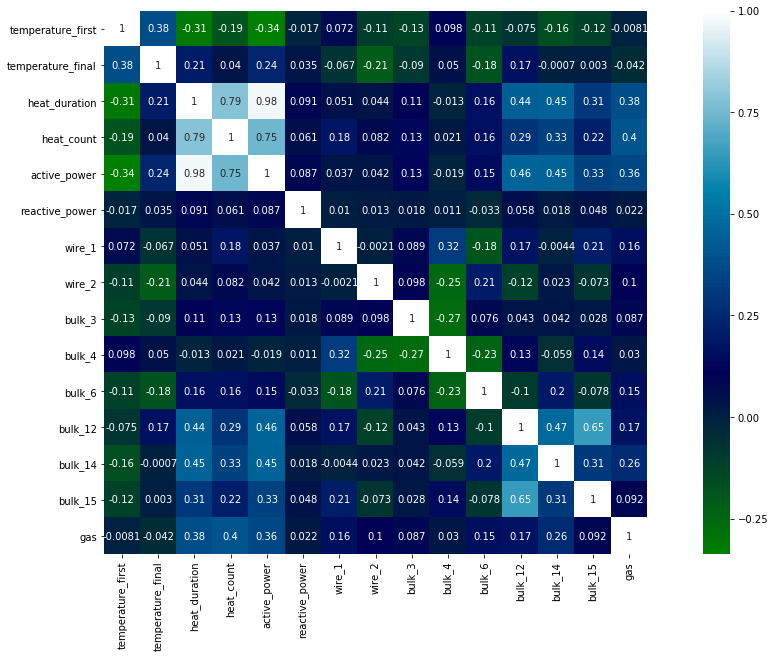

In [48]:
corr_mat=data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='ocean')
plt.show()

* Warm-up time has the strongest correlation with active power. Logically understandable, but can cause overfitting.
* Initial temperature has a large negative correlation with temperature difference. This is natural, because in order to get the temperature difference, I subtracted the initial temperature from the final one.
* Other signs have not such a significant correlation, which cannot but rejoice.

Let's clarify the information obtained on the graph of mutual correlations.

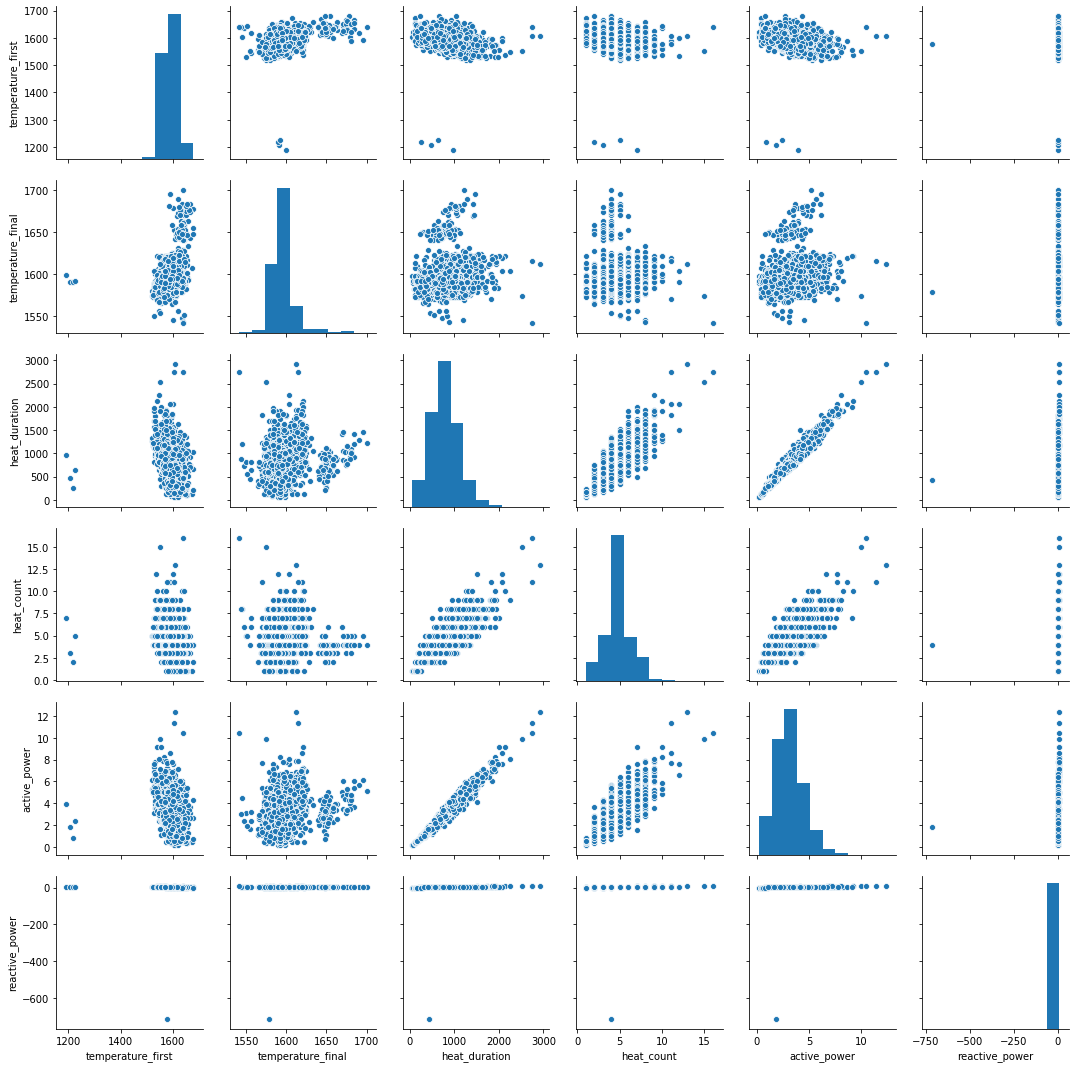

<Figure size 1440x1440 with 0 Axes>

In [49]:
sns.pairplot(data[['temperature_first', 'temperature_final','heat_duration','heat_count','active_power','reactive_power']])
plt.figure(figsize=(20,20))
plt.show()

* The above conclusions are confirmed - active power is strongly correlated with the duration of heating.
* A linear relationship of reactive power with many parameters is noticeable. I will try to somehow transform this feature in order to avoid retraining the model.

Full power is a value equal to the product of the effective values of the periodic electric current I in the circuit and the voltage U at its terminals:

$$ S = U * I $$

the ratio of apparent power to active and reactive power is expressed as follows:

$$ S = \sqrt{P^2 + Q^2} $$

where P is active power, Q is reactive power (with inductive load Q > 0, and with capacitive load Q < 0).

In accordance with the above formula, I will convert active_power and reactive_power into apparent_power.

In [50]:
data['apparent_power'] = (data['active_power']**2 + data['reactive_power']**2)**0.5

And I discard separate columns with active and reactive power.

In [51]:
data.drop(columns = ['active_power', 'reactive_power'],axis = 1, inplace=True)

In [52]:
data.head(5)

temperature_first  temperature_final  heat_duration  heat_count     wire_1  \
0             1571.0             1613.0         1098.0           5  60.059998   
1             1581.0             1602.0          811.0           4  96.052315   
2             1596.0             1599.0          655.0           5  91.160157   
3             1601.0             1625.0          741.0           4  89.063515   
4             1576.0             1602.0          869.0           4  89.238236   

    wire_2  bulk_3  bulk_4  bulk_6  bulk_12  bulk_14  bulk_15        gas  \
0  0.00000     0.0    43.0     0.0    206.0    150.0    154.0  29.749986   
1  0.00000     0.0    73.0     0.0    206.0    149.0    154.0  12.555561   
2  0.00000     0.0    34.0     0.0    205.0    152.0    153.0  28.554793   
3  0.00000     0.0    81.0     0.0    207.0    153.0    154.0  18.841219   
4  9.11456     0.0    78.0     0.0    203.0    151.0    152.0   5.413692   

   apparent_power  
0        5.824889  
1        3.648398  
2        2.989502  
3        3.813674  
4        4.034596

### Conclusion:

* There are outliers in many of the data. I have eliminated the most significant ones in the bulk_12 column.
* All temperature measurements are taken around 1600 degrees Celsius with a standard deviation of approximately 21 degrees.
* A linear dependence of reactive power with many features was found. In order to avoid retraining, the signs of active and reactive power are converted by the formula into full power.
* The rest of the data is almost uncorrelated, which is great.
* A small interval (about a week) in the temperature measurements was revealed.

I can start scaling features, dividing the dataframe into training and test sets, training models and comparing them.

# Questions for the teamlead

* Can I use the above formula?
* Perhaps it is worth discarding some of the strongly correlated features?
* Perhaps it is worth removing the initial temperature in the presence of a temperature difference?
* Did I understand correctly that the bulk_n and wire_n columns are interchangeable according to the condition of the problem?

The plan for solving the problem is described above.

### 4. Building models

Let's move on to training the model. And first of all, I will divide the final dataframe into training and test samples ***3 to 1***.

In [53]:
train, test = train_test_split(data, test_size = .25, random_state = 12345)

print('Обучающая выборка: ', train.shape, ', в процентах: ', train.shape[0]/data.shape[0]*100, '%')
print('Тестовая выборка: ', test.shape, ', в процентах: ', test.shape[0]/data.shape[0]*100, '%')

Обучающая выборка:  (1830, 14) , в процентах:  75.0 %
Тестовая выборка:  (610, 14) , в процентах:  25.0 %


I single out the target feature in both samples.

In [54]:
features_train = train.drop(['temperature_final'], axis = 1)
target_train = train['temperature_final']

features_test = test.drop(['temperature_final'], axis = 1)
target_test = test['temperature_final']

Quantitative features have a different scatter, so for a more accurate operation of the algorithms, I scale them.

In [55]:
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ('temperature_final')]

scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(train[numeric])
features_test[numeric] = scaler.transform(test[numeric])

features_test.head(5)

temperature_first  heat_duration  heat_count    wire_1    wire_2  \
456             0.46250       0.238255    0.266667  0.518560  0.000000   
1858            0.60625       0.164430    0.133333  0.042505  0.088524   
1417            0.40000       0.309471    0.466667  0.005809  0.000000   
542             0.46875       0.074944    0.066667  0.300085  0.000000   
615             0.40625       0.304623    0.200000  0.173279  0.060367   

        bulk_3    bulk_4    bulk_6   bulk_12   bulk_14   bulk_15       gas  \
456   0.000000  0.327402  0.000000  0.000000  0.176373  0.377778  0.065185   
1858  0.000000  0.000000  0.117296  0.000000  0.317804  0.000000  0.105332   
1417  0.215859  0.000000  0.000000  0.396917  0.164725  0.251852  0.168422   
542   0.000000  0.160142  0.000000  0.000000  0.000000  0.000000  0.058903   
615   0.046256  0.000000  0.000000  0.398844  0.219634  0.501235  0.209602   

      apparent_power  
456         0.213163  
1858        0.122001  
1417        0.254090  
542         0.062236  
615         0.287923

I turn to the selection of the model. I create dictionaries with models and hyperparameters.

I will use these models:

To compare its performance with those of other models
* Dummy Regressor

Basic model for regression problems. Perhaps simple means will do for the purposes of the task.
* LinearRegression

Several gradient boosting algorithms.
* LGBMRegressor
* CatBoostRegressor
* XGBRegressor

In [56]:
models = {
    'Dummy Regressor': DummyRegressor(),
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'CatBoostRegressor': CatBoostRegressor(),
    'XGBRegressor': xgboost.XGBRegressor()
    
}


params = {
    'Dummy Regressor':{'strategy': ["mean"]
    },

    'LinearRegression':{
            'fit_intercept' : [True, False],
            'normalize':[True,False]
    },
    
    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'goss'],
        'objective': ['regression'],
        'learning_rate': [0.03, 0.05],
        'num_iterations':[500],
        'random_state': [1], 
        'max_depth': np.arange(2, 10),
        'metric': ['mae']
        },
    'CatBoostRegressor':{
          'loss_function':['MAE'],
          'n_estimators': np.arange(300, 700, 100),  
          'learning_rate': [0.07, 0.11],
          'random_state':[1],
          'depth': np.arange(3, 7)
    },         
    'XGBRegressor': {
        'min_child_weight': [10,20,30],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5,10,20],
        'eval_metric' :['mae']
        }
}


Function for selecting the best parameters using `GridSearchCV` and recording the best results.

In [57]:
def fit(train_features, train_actuals, n):
    est = models[list(models.keys())[n]]
    est_params = params[list(params.keys())[n]]
    gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=6, scoring='neg_mean_absolute_error')
    gscv.fit(train_features, train_actuals)
    train_predictions = gscv.predict(features_train)
    predictions = gscv.predict(features_test)
    result_list.append({
    'model': list(models.keys())[n],
    'train_mae_score': mean_absolute_error(target_train, train_predictions),
    'test_mae_score': mean_absolute_error(target_test, predictions),
    'best_params': gscv.best_params_
    })

List for recording results.

In [58]:
result_list = []

I did not use automatic looping in order to change the models more pointwise and not wait for the processing of those that I am not busy with at a particular point in time.

##### 1. Dummy Regressor

In [59]:
%%time
fit(features_train, target_train, 0)

CPU times: user 20.9 ms, sys: 4.09 ms, total: 25 ms
Wall time: 22.5 ms


##### 2. LinearRegression

In [60]:
%%time
fit(features_train, target_train, 1)

CPU times: user 361 ms, sys: 160 ms, total: 521 ms
Wall time: 471 ms


##### 3. LGBMRegressor

In [ ]:
%%time
fit(features_train, target_train, 2)

##### 4. CatBoostRegressor

In [61]:
%%time
fit(features_train, target_train, 3)

0:	learn: 9.5078154	total: 132ms	remaining: 39.4s
1:	learn: 9.4531245	total: 133ms	remaining: 19.8s
2:	learn: 9.3317172	total: 135ms	remaining: 13.3s
3:	learn: 9.2281197	total: 136ms	remaining: 10s
4:	learn: 9.1191376	total: 136ms	remaining: 8.05s
5:	learn: 9.0599666	total: 137ms	remaining: 6.72s
6:	learn: 8.9608312	total: 138ms	remaining: 5.77s
7:	learn: 8.8879337	total: 138ms	remaining: 5.05s
8:	learn: 8.8128179	total: 140ms	remaining: 4.51s
9:	learn: 8.7265127	total: 141ms	remaining: 4.08s
10:	learn: 8.5796329	total: 141ms	remaining: 3.71s
11:	learn: 8.5089949	total: 142ms	remaining: 3.4s
12:	learn: 8.4552945	total: 143ms	remaining: 3.15s
13:	learn: 8.4119176	total: 144ms	remaining: 2.94s
14:	learn: 8.3666201	total: 144ms	remaining: 2.74s
15:	learn: 8.3101605	total: 146ms	remaining: 2.58s
16:	learn: 8.2658359	total: 146ms	remaining: 2.43s
17:	learn: 8.1927278	total: 147ms	remaining: 2.3s
18:	learn: 8.1344574	total: 147ms	remaining: 2.18s
19:	learn: 8.0198904	total: 148ms	remaining: 

##### 5. XGBRegressor

In [62]:
%%time
fit(features_train, target_train, 4)

CPU times: total: 2min 9s
Wall time: 10.5 s


I'm starting to compare the quality of the models.

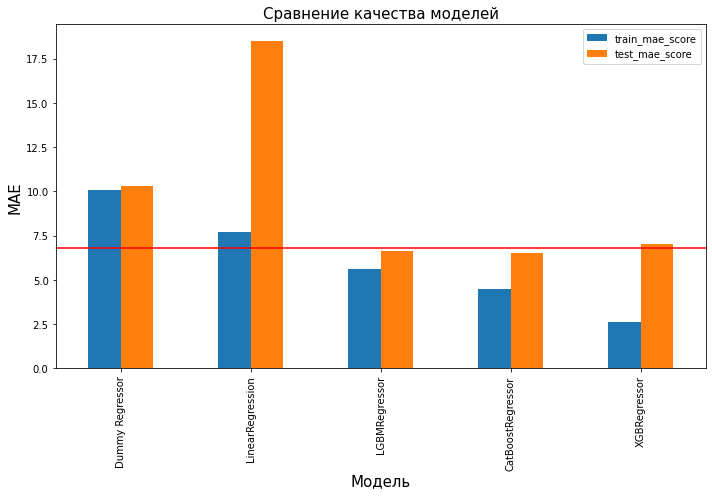

In [63]:
results = pd.DataFrame(result_list, columns=['model','train_mae_score','test_mae_score','best_params'])
results.set_index("model", inplace = True)

plt.figure(figsize=(10, 7))
plt.subplot(111)
results.plot(kind='bar', ax=plt.gca()).hlines(6.8, -1, 5, color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.title('Сравнение качества моделей', fontsize=15)
plt.tight_layout()

As you can see, only gradient boosting models cope with the task. Only they overcome the required threshold.
Also, their performance is much better than that of the Dummy-model. Linear regression is not up to the task.

Of the gradient boosting models, `CatBoostRegressor` shows the best result with ***MAE = 6.5.***

In [64]:
result_list

[{'model': 'Dummy Regressor',
  'train_mae_score': 10.101806563349154,
  'test_mae_score': 10.293057421840002,
  'best_params': {'strategy': 'mean'}},
 {'model': 'LinearRegression',
  'train_mae_score': 7.732377268793962,
  'test_mae_score': 18.510091258476653,
  'best_params': {'fit_intercept': True, 'normalize': False}},
 {'model': 'LGBMRegressor',
  'train_mae_score': 5.619109990201211,
  'test_mae_score': 6.608307474792347,
  'best_params': {'boosting_type': 'goss',
   'learning_rate': 0.03,
   'max_depth': 2,
   'metric': 'mae',
   'num_iterations': 500,
   'objective': 'regression',
   'random_state': 1}},
 {'model': 'CatBoostRegressor',
  'train_mae_score': 4.498786580260644,
  'test_mae_score': 6.539275932118566,
  'best_params': {'depth': 3,
   'learning_rate': 0.11,
   'loss_function': 'MAE',
   'n_estimators': 600,
   'random_state': 1}},
 {'model': 'XGBRegressor',
  'train_mae_score': 2.6026870810920424,
  'test_mae_score': 7.052284115650615,
  'best_params': {'colsample_by

Application of the model with the best MAE.

In [65]:
model = CatBoostRegressor(depth=6, 
                          n_estimators = 300, 
                          learning_rate = 0.07, 
                          loss_function = 'MAE', 
                          random_state = 1,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE модели на тестовых данных:', mean_absolute_error(predictions,target_test))

MAE модели на тестовых данных: 6.517269577971006


This is a good result, I will try to improve it.
It is necessary to evaluate the influence of features in the work of the model.

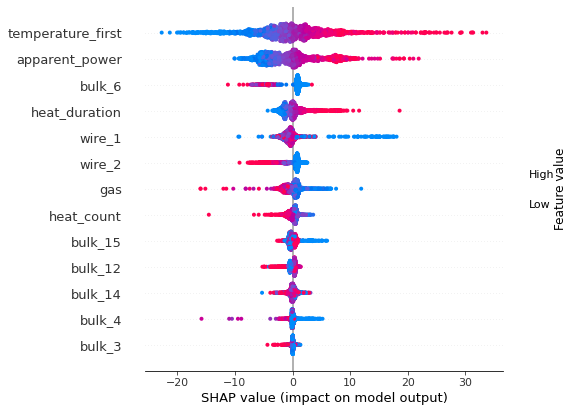

In [66]:
train_data = Pool(data=features_train,
                  label=target_train
                 )

explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(train_data) 
shap.summary_plot(shap_values, features_train, feature_names=features_train.columns.to_list())

I perform additional cleaning of the original dataframe.
Removing feature anomalies:

* bulk_6
* wire_2
* gas

##### bulk_6

Количество аномалий:  438


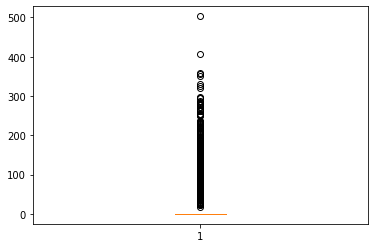

In [68]:
boxplot = plt.boxplot(data['bulk_6'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
df_outliers = data[data["bulk_6"].isin(outliers)] 
print("Количество аномалий: ", len(df_outliers))

In [69]:
data = data.drop(labels = df_outliers.index,axis = 0).reset_index(drop = True)

###### wire_2

Количество аномалий:  292


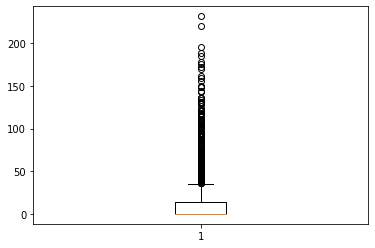

In [70]:
boxplot = plt.boxplot(data['wire_2'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
df_outliers = data[data["wire_2"].isin(outliers)] 
print("Количество аномалий: ", len(df_outliers))

In [71]:
data = data.drop(labels = df_outliers.index,axis = 0).reset_index(drop = True)

##### gas

Количество аномалий:  74


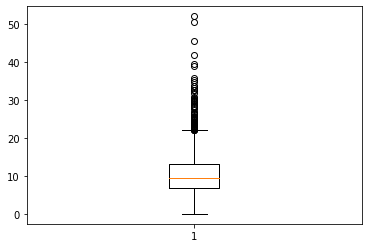

In [72]:
boxplot = plt.boxplot(data['gas'].values)
outliers = list(boxplot['fliers'][0].get_data()[1])
df_outliers = data[data["gas"].isin(outliers)] 
print("Количество аномалий: ", len(df_outliers))

In [73]:
data = data.drop(labels = df_outliers.index,axis = 0).reset_index(drop = True)

Again, I divide the dataframe into training and test sets and check MAE on the best model.

In [74]:
train, test = train_test_split(data, test_size = .25, random_state = 12345)

print('Обучающая выборка: ', train.shape, ', в процентах: ', train.shape[0]/data.shape[0]*100, '%')
print('Тестовая выборка: ', test.shape, ', в процентах: ', test.shape[0]/data.shape[0]*100, '%')

Обучающая выборка:  (1227, 14) , в процентах:  75.0 %
Тестовая выборка:  (409, 14) , в процентах:  25.0 %


I single out the target feature in both samples.

In [75]:
features_train = train.drop(['temperature_final'], axis = 1)
target_train = train['temperature_final']

features_test = test.drop(['temperature_final'], axis = 1)
target_test = test['temperature_final']

Quantitative features have a different scatter, so for a more accurate operation of the algorithms, I scale them.

In [76]:
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ('temperature_final')]

scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(train[numeric])
features_test[numeric] = scaler.transform(test[numeric])

features_test.head(5)

temperature_first  heat_duration  heat_count    wire_1  wire_2    bulk_3  \
647           0.815574       0.284646         0.3  0.387942     0.0  0.096203   
361           0.772541       0.312064         0.3  0.404793     0.0  0.000000   
154           0.834016       0.207378         0.3  0.189078     0.0  0.000000   
979           0.838115       0.202891         0.3  0.621232     0.0  0.326582   
131           0.819672       0.323529         0.3  0.708257     0.0  0.000000   

       bulk_4  bulk_6   bulk_12   bulk_14   bulk_15       gas  apparent_power  
647  0.000000     0.0  0.304264  0.280899  0.251852  0.222060        0.249286  
361  0.000000     0.0  0.000000  0.303371  0.002469  0.647551        0.282389  
154  0.348754     0.0  0.397287  0.429775  0.377778  0.519969        0.194347  
979  0.000000     0.0  0.207364  0.362360  0.180247  0.409088        0.209397  
131  0.498221     0.0  0.238372  0.362360  0.501235  0.427633        0.300328

In [77]:
model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE модели на тестовых данных:', mean_absolute_error(predictions,target_test))

MAE модели на тестовых данных: 5.60674996878118


The result ***MAE = 5.6*** is great.

### Conclusion:

* The data is divided into training and test samples in the proportion of 3 to 1. The target feature is separated.
* Quantitative features scaled.
* Three variants of gradient boosting models and a linear regression model were tested.
* Hyperparameters were selected using GridSearchCV.
* The linear model did not cope with the task, but the gradient boosting models performed well.
* Of these, the CatBoostRegressor model with MAE = 6.5 on the test sample copes best with the task.
* The influence of features was estimated using the shap library.
* Additionally eliminated anomalies in bulk_6, wire_2 and gas.
* The model has been trained again and now shows MAE = 5.6 on the test set.
* Desired result achieved. Task completed successfully.

### 5. General Conclusion:

After all:

* I carried out the primary analysis of the provided dataframes.
* The next step was pre-processing: clearing gaps in the data, checking for complete duplicates, changing data types.
* The target feature was defined and some features were created, which were then effectively used in training the model.
* Dataframes provided have been merged by batch number `key`
* Next, I embarked on an exploratory data analysis, during which:
* Removed most notable outliers
    * Estimated results of temperature measurements over time
    * Checked for multicollinearity
    * Estimated data distributions on the cross-correlation graph
    * It was decided to convert the data on active and reactive power according to the apparent power formula and discard some features in order to avoid retraining the model
* Before training the model, the dataframe was divided into training and test sets in a ratio of 3 to 1
* Selected target feature
* The rest of the data has been scaled
* Using auto-selection of parameters, it was determined that gradient boosting models are the most suitable for the purposes of the project
* The CatBoostRegressor model performed best with MAE = 6.5 on the test set
* Further, the analysis of the influence of features during the training of the model was carried out
* Additional cleaning of some of them from anomalies
* The model with the best parameters was again trained on the final data, which was again split and scaled
* As a result, the CatBoostRegressor model was trained with the indicator ***MAE = 5.6***, which, according to the conditions of the task, overcomes the maximum possible threshold MAE ≤ 6.0

In order to further optimize the model, it is possible to reduce the spread in temperature measurements, as the most important feature in the learning process. Perhaps a model is needed to capture the anomaly of the measurement result.